#### Paraneters to optimize 
Generally:
* number of layers in NN: 1, 2

Locally:
* activation function:relu, than, sigmoid
* number of neurons: 5,10,20
* learning rate: 0.001, 0.0005, 0.0001, 0.00005, learning rate scheduler?
* regularization: L2 penalty, dropout
* batch size: 16, 32, 64
* number of epochs

Way of choosing the hyperparameters - k-fold cross-validation 



In [1]:
from pathlib import Path
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from NegativeClassOptimization import ml


In [2]:
input_dim = 67*100

In [3]:
neurons = [5, 10, 20, 30]                   # Number of neurons
activations = ['relu']   # Activation functions
learning_rates = [0.001, 0.0005, 0.0001]       # Learning rates

# Create all possible combinations
param_combinations = list(itertools.product(neurons, activations, learning_rates))

In [4]:
optimizer_type = "Adam"

In [6]:
param_combinations

[(5, 'relu', 0.001),
 (5, 'relu', 0.0005),
 (5, 'relu', 0.0001),
 (10, 'relu', 0.001),
 (10, 'relu', 0.0005),
 (10, 'relu', 0.0001),
 (20, 'relu', 0.001),
 (20, 'relu', 0.0005),
 (20, 'relu', 0.0001),
 (30, 'relu', 0.001),
 (30, 'relu', 0.0005),
 (30, 'relu', 0.0001)]

In [8]:
#maybe I will split the function into several but later:) 

def run_optimization(target, task, split=0, epochs=10, batch_size=32, momentum=0.9):
        path_to_target = Path('./data/processed') / target
        path_vs_task_split = path_to_target / task / f'split_{split}'
        path_to_train = path_vs_task_split / 'train.pkl'
        df = pd.read_pickle(path_to_train)
        X = np.array(df["X"].tolist())
        y = np.array(df["Y_binary"].tolist())

        kfl = KFold(n_splits=3, shuffle=True, random_state=42)
        param_search = []

        for neurons, activation, learning_rate in param_combinations:
                model = ml.SNN(num_hidden_units=neurons, input_dim=input_dim, activation_function=activation)
                fold_metrics = []
                for train_index, val_index in kfl.split(X):  # k-fold loop, we will average over it
                        X_train = X[train_index]
                        y_train = y[train_index]
                        X_val = X[val_index]
                        y_val = y[val_index]

                        X_tensor_train = torch.tensor(X_train, dtype=torch.float32)
                        y_tensor_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
                        X_tensor_val = torch.tensor(X_val, dtype=torch.float32)
                        y_tensor_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

                        dataset_train = TensorDataset(X_tensor_train, y_tensor_train)
                        dataset_val = TensorDataset(X_tensor_val, y_tensor_val)

                        train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True) #we need to be able to change batch size
                        val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

                        train_output = ml.train_for_ndb1(
                                epochs,
                                learning_rate,
                                train_loader=train_loader,
                                test_loader=val_loader,
                                model=model,
                                optimizer_type=optimizer_type,
                                momentum=momentum,
                                swa=True,
                                open_loader=None,
                        ) #we need to be able to change epochs

                        swa_model, model, online_metrics = train_output

                        acc = online_metrics[-1]["test_metrics"]["acc_closed"]
                        fold_metrics.append(acc)

                avg_metric = sum(fold_metrics) / len(fold_metrics)
                param_search.append((neurons, activation, learning_rate, avg_metric))

        return param_search


In [9]:
targets_balanced_list = ['Q96GD4', 'P49841', 'Q13627', 'P06239', 'Q13464', 'P11309']
tasks = ['vs_Weak', 'vs_all', 'vs_Non-binder', 'shuffled_weak']
ag_task_wide_params = []
for target in targets_balanced_list:
    for task in tasks:
        param_search = run_optimization(target, task, split=0, epochs=10, batch_size=32, momentum=0.9)
        df = pd.DataFrame(param_search, columns=['neurons', 'activation', 'learning_rate', 'accuracy'])
        df['task'] = task
        df['target'] = target
        ag_task_wide_params.append(df)
df = pd.concat(ag_task_wide_params)


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/skl

In [12]:
df

,neurons,activation,learning_rate,accuracy,task,target
0,5,relu,0.0010,0.738358,vs_Weak,Q96GD4
1,5,relu,0.0005,0.734592,vs_Weak,Q96GD4
2,5,relu,0.0001,0.736464,vs_Weak,Q96GD4
3,10,relu,0.0010,0.748002,vs_Weak,Q96GD4
4,10,relu,0.0005,0.744171,vs_Weak,Q96GD4
...,...,...,...,...,...,...
7,20,relu,0.0005,0.719101,shuffled_weak,P11309
8,20,relu,0.0001,0.713483,shuffled_weak,P11309
9,30,relu,0.0010,0.764045,shuffled_weak,P11309
10,30,relu,0.0005,0.734082,shuffled_weak,P11309


In [13]:
df.to_csv("ml_arch_params_search_ag.csv")


In [14]:
df = pd.read_csv("ml_arch_params_search_ag.csv")

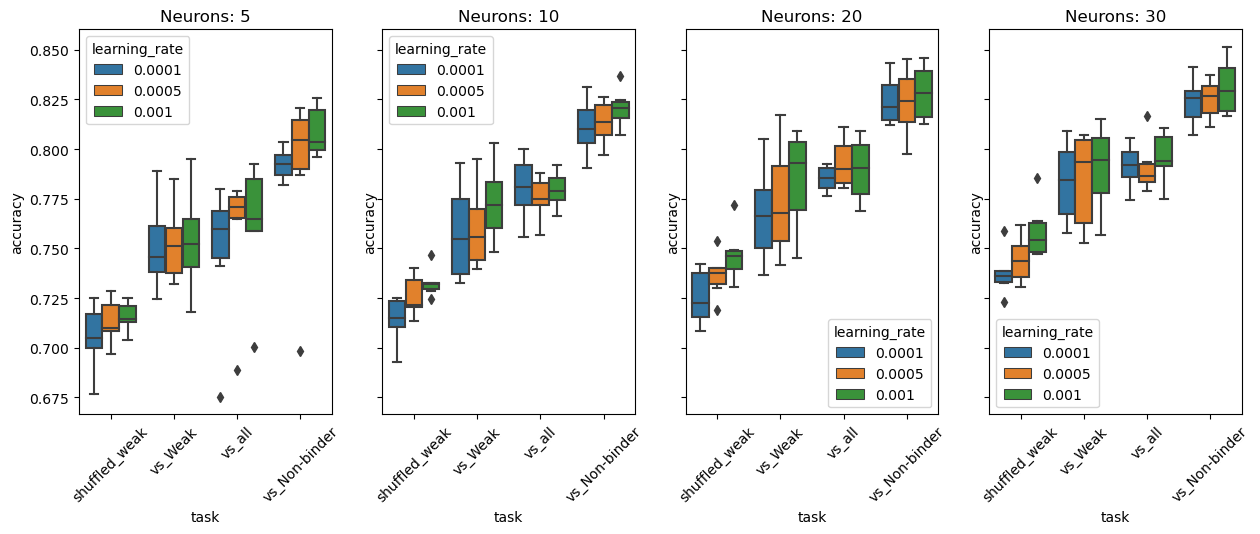

In [16]:
#for i, df in df_ml_arch_param.groupby("neurons"):
fig, ax = plt.subplots(1,4, sharey=True, figsize=(15,5))
for i, (n_neuron, df_neuron) in enumerate(df.groupby("neurons")):
    sns.boxplot(x='task', y='accuracy', hue='learning_rate', data=df_neuron, ax=ax[i], order=['shuffled_weak', 'vs_Weak', 'vs_all', 'vs_Non-binder'])
    ax[i].set_title(f'Neurons: {n_neuron}')
    ax[i].xaxis.set_tick_params(rotation=45)

In [17]:
#we can optimize epoch number and batch size as well

targets_balanced_list = ['Q96GD4', 'P49841', 'Q13627', 'P06239', 'Q13464', 'P11309']
tasks = ['vs_Weak', 'vs_all', 'vs_Non-binder', 'shuffled_weak']
param_combinations = [(10, 'relu', 0.001)]
batch_size_params = [8, 16, 32, 64]
epochs_param = [10, 20, 30, 40, 100]
training_params = list(itertools.product(batch_size_params, epochs_param))

epochs_bsize_params = []
for target in tqdm(targets_balanced_list, desc='Targets'):
    for task in tqdm(tasks, desc='Task'):
        for batch_size, epoch in tqdm(training_params, desc='Training Params'):
            param_search = run_optimization(target, task, split=0, epochs=epoch, batch_size=batch_size, momentum=0.9)
            df = pd.DataFrame(param_search, columns=['neurons', 'activation', 'learning_rate', 'accuracy'])
            df['task'] = task
            df['target'] = target
            df['epochs'] = epoch
            df['batch_size'] = batch_size
            print(df)
            epochs_bsize_params.append(df)
df_epochs_bsize_params = pd.concat(epochs_bsize_params)

Targets:   0%|          | 0/6 [00:00<?, ?it/s]



   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.790192  vs_Weak  Q96GD4      10   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.771067  vs_Weak  Q96GD4      20   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.786371  vs_Weak  Q96GD4      30   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.795928  vs_Weak  Q96GD4      40   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.776825  vs_Weak  Q96GD4     100   

   batch_size  
0           8  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.772885  vs_Weak  Q96GD4      10   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.794001  vs_Weak  Q96GD4      20   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.784488  vs_Weak  Q96GD4      30   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.782562  vs_Weak  Q96GD4      40   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.784423  vs_Weak  Q96GD4     100   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.755632  vs_Weak  Q96GD4      10   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.786349  vs_Weak  Q96GD4      20   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.794023  vs_Weak  Q96GD4      30   

   batch_size  
0          32  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.795961  vs_Weak  Q96GD4      40   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.778719  vs_Weak  Q96GD4     100   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.728834  vs_Weak  Q96GD4      10   

   batch_size  
0          64  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.772939  vs_Weak  Q96GD4      20   

   batch_size  
0          64  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.790148  vs_Weak  Q96GD4      30   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.799737  vs_Weak  Q96GD4      40   

   batch_size  
0          64  



Training Params: 100%|██████████| 20/20 [05:49<00:00, 17.50s/it]


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001   0.78636  vs_Weak  Q96GD4     100   

   batch_size  
0          64  



/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.805452  vs_all  Q96GD4      10   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.807302  vs_all  Q96GD4      20   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.797756  vs_all  Q96GD4      30   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001   0.80925  vs_all  Q96GD4      40   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.807313  vs_all  Q96GD4     100   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.799715  vs_all  Q96GD4      10   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.805419  vs_all  Q96GD4      20   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.813071  vs_all  Q96GD4      30   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.820712  vs_all  Q96GD4      40   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.799639  vs_all  Q96GD4     100   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.776705  vs_all  Q96GD4      10   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.807334  vs_all  Q96GD4      20   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.814986  vs_all  Q96GD4      30   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001   0.80543  vs_all  Q96GD4      40   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001   0.80543  vs_all  Q96GD4     100   

   batch_size  
0          32  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.770914  vs_all  Q96GD4      10   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.797811  vs_all  Q96GD4      20   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.811188  vs_all  Q96GD4      30   

   batch_size  
0          64  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.811166  vs_all  Q96GD4      40   

   batch_size  
0          64  



Training Params: 100%|██████████| 20/20 [05:27<00:00, 16.38s/it]


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.805419  vs_all  Q96GD4     100   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.837833  vs_Non-binder  Q96GD4      10   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.849327  vs_Non-binder  Q96GD4      20   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.843591  vs_Non-binder  Q96GD4      30   

   batch_size  
0           8  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.845528  vs_Non-binder  Q96GD4      40   

   batch_size  
0           8  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.837833  vs_Non-binder  Q96GD4     100   

   batch_size  
0           8  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001   0.83399  vs_Non-binder  Q96GD4      10   

   batch_size  
0          16  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.851232  vs_Non-binder  Q96GD4      20   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.834034  vs_Non-binder  Q96GD4      30   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.837854  vs_Non-binder  Q96GD4      40   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.822529  vs_Non-binder  Q96GD4     100   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.832053  vs_Non-binder  Q96GD4      10   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.841697  vs_Non-binder  Q96GD4      20   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.855052  vs_Non-binder  Q96GD4      30   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.856979  vs_Non-binder  Q96GD4      40   

   batch_size  
0          32  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.855063  vs_Non-binder  Q96GD4     100   

   batch_size  
0          32  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.809064  vs_Non-binder  Q96GD4      10   

   batch_size  
0          64  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.839759  vs_Non-binder  Q96GD4      20   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.839737  vs_Non-binder  Q96GD4      30   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.851232  vs_Non-binder  Q96GD4      40   

   batch_size  
0          64  



Training Params: 100%|██████████| 20/20 [05:15<00:00, 15.79s/it]


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.837854  vs_Non-binder  Q96GD4     100   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.751856  shuffled_weak  Q96GD4      10   

   batch_size  
0           8  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.765276  shuffled_weak  Q96GD4      20   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.767225  shuffled_weak  Q96GD4      30   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.755742  shuffled_weak  Q96GD4      40   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.744258  shuffled_weak  Q96GD4     100   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.749885  shuffled_weak  Q96GD4      10   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.757668  shuffled_weak  Q96GD4      20   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.763361  shuffled_weak  Q96GD4      30   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.772939  shuffled_weak  Q96GD4      40   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.761456  shuffled_weak  Q96GD4     100   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.734516  shuffled_weak  Q96GD4      10   

   batch_size  
0          32  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.757581  shuffled_weak  Q96GD4      20   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.755753  shuffled_weak  Q96GD4      30   

   batch_size  
0          32  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.765287  shuffled_weak  Q96GD4      40   

   batch_size  
0          32  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.759562  shuffled_weak  Q96GD4     100   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001   0.72301  shuffled_weak  Q96GD4      10   

   batch_size  
0          64  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.734647  shuffled_weak  Q96GD4      20   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.751877  shuffled_weak  Q96GD4      30   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.751899  shuffled_weak  Q96GD4      40   

   batch_size  
0          64  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

Targets:  17%|█▋        | 1/6 [21:42<1:48:33, 1302.63s/it]

   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.774833  shuffled_weak  Q96GD4     100   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.824087  vs_Weak  P49841      10   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.815695  vs_Weak  P49841      20   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.805619  vs_Weak  P49841      30   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.807286  vs_Weak  P49841      40   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.797244  vs_Weak  P49841     100   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.805568  vs_Weak  P49841      10   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.810661  vs_Weak  P49841      20   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.817378  vs_Weak  P49841      30   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.814028  vs_Weak  P49841      40   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.803944  vs_Weak  P49841     100   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.782067  vs_Weak  P49841      10   

   batch_size  
0          32  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.817378  vs_Weak  P49841      20   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.810678  vs_Weak  P49841      30   

   batch_size  
0          32  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.815712  vs_Weak  P49841      40   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.815695  vs_Weak  P49841     100   

   batch_size  
0          32  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.753557  vs_Weak  P49841      10   

   batch_size  
0          64  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.822395  vs_Weak  P49841      20   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001   0.81572  vs_Weak  P49841      30   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.814045  vs_Weak  P49841      40   

   batch_size  
0          64  



Training Params: 100%|██████████| 20/20 [05:58<00:00, 17.94s/it]


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.805653  vs_Weak  P49841     100   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.813977  vs_all  P49841      10   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.827428  vs_all  P49841      20   

   batch_size  
0           8  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.847563  vs_all  P49841      30   

   batch_size  
0           8  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.825762  vs_all  P49841      40   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001   0.80391  vs_all  P49841     100   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.793834  vs_all  P49841      10   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.834145  vs_all  P49841      20   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.815678  vs_all  P49841      30   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.819062  vs_all  P49841      40   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.815703  vs_all  P49841     100   

   batch_size  
0          16  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.782092  vs_all  P49841      10   

   batch_size  
0          32  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001   0.82742  vs_all  P49841      20   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.820711  vs_all  P49841      30   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.819045  vs_all  P49841      40   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001   0.81737  vs_all  P49841     100   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.748507  vs_all  P49841      10   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.805602  vs_all  P49841      20   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.824053  vs_all  P49841      30   

   batch_size  
0          64  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.829095  vs_all  P49841      40   

   batch_size  
0          64  



Training Params: 100%|██████████| 20/20 [05:49<00:00, 17.45s/it]


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.820737  vs_all  P49841     100   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.829053  vs_Non-binder  P49841      10   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.844179  vs_Non-binder  P49841      20   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.837453  vs_Non-binder  P49841      30   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.835761  vs_Non-binder  P49841      40   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.822361  vs_Non-binder  P49841     100   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.832369  vs_Non-binder  P49841      10   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.837462  vs_Non-binder  P49841      20   

   batch_size  
0          16  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001   0.83577  vs_Non-binder  P49841      30   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.835778  vs_Non-binder  P49841      40   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.827378  vs_Non-binder  P49841     100   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.805534  vs_Non-binder  P49841      10   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.837453  vs_Non-binder  P49841      20   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.832428  vs_Non-binder  P49841      30   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.839128  vs_Non-binder  P49841      40   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.830736  vs_Non-binder  P49841     100   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.795442  vs_Non-binder  P49841      10   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.824011  vs_Non-binder  P49841      20   

   batch_size  
0          64  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.844153  vs_Non-binder  P49841      30   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.837445  vs_Non-binder  P49841      40   

   batch_size  
0          64  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

Training Params: 100%|██████████| 20/20 [05:47<00:00, 17.37s/it]


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.834112  vs_Non-binder  P49841     100   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.788776  shuffled_weak  P49841      10   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.829087  shuffled_weak  P49841      20   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.817344  shuffled_weak  P49841      30   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.805551  shuffled_weak  P49841      40   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.805577  shuffled_weak  P49841     100   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.788767  shuffled_weak  P49841      10   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001   0.83412  shuffled_weak  P49841      20   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.827411  shuffled_weak  P49841      30   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.825736  shuffled_weak  P49841      40   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001   0.82407  shuffled_weak  P49841     100   

   batch_size  
0          16  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.746823  shuffled_weak  P49841      10   

   batch_size  
0          32  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.813977  shuffled_weak  P49841      20   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001   0.82407  shuffled_weak  P49841      30   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.827428  shuffled_weak  P49841      40   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.825745  shuffled_weak  P49841     100   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.731731  shuffled_weak  P49841      10   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.793818  shuffled_weak  P49841      20   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.810619  shuffled_weak  P49841      30   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.814011  shuffled_weak  P49841      40   

   batch_size  
0          64  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

Targets:  33%|███▎      | 2/6 [45:15<1:31:09, 1367.40s/it]

   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.820694  shuffled_weak  P49841     100   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.827212  vs_Weak  Q13627      10   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.819204  vs_Weak  Q13627      20   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.843325  vs_Weak  Q13627      30   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001   0.82524  vs_Weak  Q13627      40   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.821176  vs_Weak  Q13627     100   

   batch_size  
0           8  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.821188  vs_Weak  Q13627      10   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.835256  vs_Weak  Q13627      20   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.829256  vs_Weak  Q13627      30   

   batch_size  
0          16  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.829256  vs_Weak  Q13627      40   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001   0.81716  vs_Weak  Q13627     100   

   batch_size  
0          16  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.795023  vs_Weak  Q13627      10   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.835268  vs_Weak  Q13627      20   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.851357  vs_Weak  Q13627      30   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.825228  vs_Weak  Q13627      40   

   batch_size  
0          32  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.825216  vs_Weak  Q13627     100   

   batch_size  
0          32  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.772837  vs_Weak  Q13627      10   

   batch_size  
0          64  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.819155  vs_Weak  Q13627      20   

   batch_size  
0          64  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001   0.83124  vs_Weak  Q13627      30   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.831264  vs_Weak  Q13627      40   

   batch_size  
0          64  



Training Params: 100%|██████████| 20/20 [05:17<00:00, 15.88s/it]


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.835281  vs_Weak  Q13627     100   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.801022  vs_all  Q13627      10   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.801047  vs_all  Q13627      20   

   batch_size  
0           8  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.792978  vs_all  Q13627      30   

   batch_size  
0           8  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.805051  vs_all  Q13627      40   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.788986  vs_all  Q13627     100   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.786978  vs_all  Q13627      10   

   batch_size  
0          16  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.801034  vs_all  Q13627      20   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.799002  vs_all  Q13627      30   

   batch_size  
0          16  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.801047  vs_all  Q13627      40   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.795023  vs_all  Q13627     100   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.778897  vs_all  Q13627      10   

   batch_size  
0          32  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.809115  vs_all  Q13627      20   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.803103  vs_all  Q13627      30   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.805111  vs_all  Q13627      40   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.793039  vs_all  Q13627     100   

   batch_size  
0          32  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001   0.75272  vs_all  Q13627      10   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001   0.79299  vs_all  Q13627      20   

   batch_size  
0          64  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.799063  vs_all  Q13627      30   

   batch_size  
0          64  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.797043  vs_all  Q13627      40   

   batch_size  
0          64  



Training Params: 100%|██████████| 20/20 [04:51<00:00, 14.55s/it]


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.790982  vs_all  Q13627     100   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.831191  vs_Non-binder  Q13627      10   

   batch_size  
0           8  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.833199  vs_Non-binder  Q13627      20   

   batch_size  
0           8  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.837276  vs_Non-binder  Q13627      30   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.831191  vs_Non-binder  Q13627      40   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.825155  vs_Non-binder  Q13627     100   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.821163  vs_Non-binder  Q13627      10   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.843288  vs_Non-binder  Q13627      20   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.833212  vs_Non-binder  Q13627      30   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.839248  vs_Non-binder  Q13627      40   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.823147  vs_Non-binder  Q13627     100   

   batch_size  
0          16  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.829171  vs_Non-binder  Q13627      10   

   batch_size  
0          32  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001   0.84128  vs_Non-binder  Q13627      20   

   batch_size  
0          32  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.841292  vs_Non-binder  Q13627      30   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.839272  vs_Non-binder  Q13627      40   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.829208  vs_Non-binder  Q13627     100   

   batch_size  
0          32  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.780869  vs_Non-binder  Q13627      10   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.831191  vs_Non-binder  Q13627      20   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.821127  vs_Non-binder  Q13627      30   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.831216  vs_Non-binder  Q13627      40   

   batch_size  
0          64  



Training Params: 100%|██████████| 20/20 [04:54<00:00, 14.74s/it]


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.833212  vs_Non-binder  Q13627     100   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001   0.78497  shuffled_weak  Q13627      10   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.766947  shuffled_weak  Q13627      20   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.781027  shuffled_weak  Q13627      30   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.787015  shuffled_weak  Q13627      40   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.728575  shuffled_weak  Q13627     100   

   batch_size  
0           8  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001   0.74072  shuffled_weak  Q13627      10   

   batch_size  
0          16  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/skl

   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.779007  shuffled_weak  Q13627      20   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.774954  shuffled_weak  Q13627      30   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.781003  shuffled_weak  Q13627      40   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.775027  shuffled_weak  Q13627     100   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.722624  shuffled_weak  Q13627      10   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.768918  shuffled_weak  Q13627      20   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.789108  shuffled_weak  Q13627      30   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.766971  shuffled_weak  Q13627      40   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.777035  shuffled_weak  Q13627     100   

   batch_size  
0          32  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.696398  shuffled_weak  Q13627      10   

   batch_size  
0          64  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/skl

   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.766861  shuffled_weak  Q13627      20   

   batch_size  
0          64  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.770938  shuffled_weak  Q13627      30   

   batch_size  
0          64  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.772971  shuffled_weak  Q13627      40   

   batch_size  
0          64  



Targets:  50%|█████     | 3/6 [1:05:17<1:04:35, 1291.90s/it]

   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.772959  shuffled_weak  Q13627     100   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.814695  vs_Weak  P06239      10   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.833131  vs_Weak  P06239      20   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.811052  vs_Weak  P06239      30   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001   0.82028  vs_Weak  P06239      40   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.823933  vs_Weak  P06239     100   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001   0.79816  vs_Weak  P06239      10   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.825795  vs_Weak  P06239      20   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.827616  vs_Weak  P06239      30   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.816587  vs_Weak  P06239      40   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.807358  vs_Weak  P06239     100   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.777872  vs_Weak  P06239      10   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.823933  vs_Weak  P06239      20   

   batch_size  
0          32  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.812893  vs_Weak  P06239      30   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.833141  vs_Weak  P06239      40   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.816546  vs_Weak  P06239     100   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001   0.74108  vs_Weak  P06239      10   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001   0.80921  vs_Weak  P06239      20   

   batch_size  
0          64  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.803716  vs_Weak  P06239      30   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001   0.82029  vs_Weak  P06239      40   

   batch_size  
0          64  



Training Params: 100%|██████████| 20/20 [05:31<00:00, 16.60s/it]


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.812883  vs_Weak  P06239     100   

   batch_size  
0          64  



/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001   0.83306  vs_all  P06239      10   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001   0.83308  vs_all  P06239      20   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.842288  vs_all  P06239      30   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.820189  vs_all  P06239      40   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.834912  vs_all  P06239     100   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001   0.80917  vs_all  P06239      10   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.840447  vs_all  P06239      20   

   batch_size  
0          16  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.842258  vs_all  P06239      30   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.831249  vs_all  P06239      40   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.827606  vs_all  P06239     100   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.794447  vs_all  P06239      10   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001   0.83308  vs_all  P06239      20   

   batch_size  
0          32  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.834922  vs_all  P06239      30   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001   0.83307  vs_all  P06239      40   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.822061  vs_all  P06239     100   

   batch_size  
0          32  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.772398  vs_all  P06239      10   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.831239  vs_all  P06239      20   

   batch_size  
0          64  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.836753  vs_all  P06239      30   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.836753  vs_all  P06239      40   

   batch_size  
0          64  



Training Params: 100%|██████████| 20/20 [05:22<00:00, 16.13s/it]


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.820209  vs_all  P06239     100   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.849625  vs_Non-binder  P06239      10   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.860674  vs_Non-binder  P06239      20   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.856981  vs_Non-binder  P06239      30   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.853277  vs_Non-binder  P06239      40   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.851446  vs_Non-binder  P06239     100   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.849594  vs_Non-binder  P06239      10   

   batch_size  
0          16  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.853328  vs_Non-binder  P06239      20   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.856981  vs_Non-binder  P06239      30   

   batch_size  
0          16  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.855149  vs_Non-binder  P06239      40   

   batch_size  
0          16  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.840416  vs_Non-binder  P06239     100   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.823842  vs_Non-binder  P06239      10   

   batch_size  
0          32  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.862486  vs_Non-binder  P06239      20   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.856981  vs_Non-binder  P06239      30   

   batch_size  
0          32  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.851466  vs_Non-binder  P06239      40   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.840406  vs_Non-binder  P06239     100   

   batch_size  
0          32  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.810951  vs_Non-binder  P06239      10   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.855149  vs_Non-binder  P06239      20   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.851466  vs_Non-binder  P06239      30   

   batch_size  
0          64  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.853308  vs_Non-binder  P06239      40   

   batch_size  
0          64  



Training Params: 100%|██████████| 20/20 [05:28<00:00, 16.43s/it]


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.842258  vs_Non-binder  P06239     100   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.757726  shuffled_weak  P06239      10   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.781697  shuffled_weak  P06239      20   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.778044  shuffled_weak  P06239      30   

   batch_size  
0           8  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.779866  shuffled_weak  P06239      40   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.757756  shuffled_weak  P06239     100   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.743013  shuffled_weak  P06239      10   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.792747  shuffled_weak  P06239      20   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.779866  shuffled_weak  P06239      30   

   batch_size  
0          16  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001   0.79641  shuffled_weak  P06239      40   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.770658  shuffled_weak  P06239     100   

   batch_size  
0          16  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001   0.72829  shuffled_weak  P06239      10   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.783539  shuffled_weak  P06239      20   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.787212  shuffled_weak  P06239      30   

   batch_size  
0          32  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.774341  shuffled_weak  P06239      40   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.781717  shuffled_weak  P06239     100   

   batch_size  
0          32  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.702528  shuffled_weak  P06239      10   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.772479  shuffled_weak  P06239      20   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001   0.78539  shuffled_weak  P06239      30   

   batch_size  
0          64  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001   0.78536  shuffled_weak  P06239      40   

   batch_size  
0          64  



Targets:  67%|██████▋   | 4/6 [1:27:17<43:25, 1302.91s/it]  

   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.770668  shuffled_weak  P06239     100   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.797458  vs_Weak  Q13464      10   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.803774  vs_Weak  Q13464      20   

   batch_size  
0           8  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.799646  vs_Weak  Q13464      30   

   batch_size  
0           8  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.801769  vs_Weak  Q13464      40   

   batch_size  
0           8  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.770349  vs_Weak  Q13464     100   

   batch_size  
0           8  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.776428  vs_Weak  Q13464      10   

   batch_size  
0          16  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001   0.80798  vs_Weak  Q13464      20   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.814269  vs_Weak  Q13464      30   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.799659  vs_Weak  Q13464      40   

   batch_size  
0          16  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.795466  vs_Weak  Q13464     100   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.742938  vs_Weak  Q13464      10   

   batch_size  
0          32  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.805909  vs_Weak  Q13464      20   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.812199  vs_Weak  Q13464      30   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.812225  vs_Weak  Q13464      40   

   batch_size  
0          32  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001   0.79548  vs_Weak  Q13464     100   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.711478  vs_Weak  Q13464      10   

   batch_size  
0          64  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/skl

   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.799594  vs_Weak  Q13464      20   

   batch_size  
0          64  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.799633  vs_Weak  Q13464      30   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001    0.8038  vs_Weak  Q13464      40   

   batch_size  
0          64  



Training Params: 100%|██████████| 20/20 [04:33<00:00, 13.67s/it]


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.805909  vs_Weak  Q13464     100   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.785076  vs_all  Q13464      10   

   batch_size  
0           8  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.803931  vs_all  Q13464      20   

   batch_size  
0           8  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.808137  vs_all  Q13464      30   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.799686  vs_all  Q13464      40   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.801769  vs_all  Q13464     100   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.795519  vs_all  Q13464      10   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.799725  vs_all  Q13464      20   

   batch_size  
0          16  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.799777  vs_all  Q13464      30   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.795545  vs_all  Q13464      40   

   batch_size  
0          16  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.795506  vs_all  Q13464     100   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.776638  vs_all  Q13464      10   

   batch_size  
0          32  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.797655  vs_all  Q13464      20   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.793449  vs_all  Q13464      30   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.797628  vs_all  Q13464      40   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.801821  vs_all  Q13464     100   

   batch_size  
0          32  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.747248  vs_all  Q13464      10   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.787172  vs_all  Q13464      20   

   batch_size  
0          64  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/skl

   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.791339  vs_all  Q13464      30   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.797642  vs_all  Q13464      40   

   batch_size  
0          64  



Training Params: 100%|██████████| 20/20 [04:36<00:00, 13.81s/it]


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.795545  vs_all  Q13464     100   

   batch_size  
0          64  



/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.849725  vs_Non-binder  Q13464      10   

   batch_size  
0           8  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.851834  vs_Non-binder  Q13464      20   

   batch_size  
0           8  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.849777  vs_Non-binder  Q13464      30   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.849764  vs_Non-binder  Q13464      40   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.847628  vs_Non-binder  Q13464     100   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.843409  vs_Non-binder  Q13464      10   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.860181  vs_Non-binder  Q13464      20   

   batch_size  
0          16  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.851834  vs_Non-binder  Q13464      30   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.847655  vs_Non-binder  Q13464      40   

   batch_size  
0          16  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.847642  vs_Non-binder  Q13464     100   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001   0.82876  vs_Non-binder  Q13464      10   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.856001  vs_Non-binder  Q13464      20   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.858111  vs_Non-binder  Q13464      30   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.860207  vs_Non-binder  Q13464      40   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.851821  vs_Non-binder  Q13464     100   

   batch_size  
0          32  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.774397  vs_Non-binder  Q13464      10   

   batch_size  
0          64  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.839308  vs_Non-binder  Q13464      20   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.849751  vs_Non-binder  Q13464      30   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.853918  vs_Non-binder  Q13464      40   

   batch_size  
0          64  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/skl

   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.870663  vs_Non-binder  Q13464     100   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.766274  shuffled_weak  Q13464      10   

   batch_size  
0           8  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001   0.77044  shuffled_weak  Q13464      20   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.770466  shuffled_weak  Q13464      30   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.774686  shuffled_weak  Q13464      40   

   batch_size  
0           8  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.757862  shuffled_weak  Q13464     100   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.734775  shuffled_weak  Q13464      10   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.770453  shuffled_weak  Q13464      20   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001   0.76837  shuffled_weak  Q13464      30   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.764177  shuffled_weak  Q13464      40   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.778892  shuffled_weak  Q13464     100   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.718056  shuffled_weak  Q13464      10   

   batch_size  
0          32  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.780896  shuffled_weak  Q13464      20   

   batch_size  
0          32  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.770466  shuffled_weak  Q13464      30   

   batch_size  
0          32  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.766313  shuffled_weak  Q13464      40   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.768331  shuffled_weak  Q13464     100   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.709631  shuffled_weak  Q13464      10   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.764151  shuffled_weak  Q13464      20   

   batch_size  
0          64  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/skl

   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.768344  shuffled_weak  Q13464      30   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.762055  shuffled_weak  Q13464      40   

   batch_size  
0          64  



Targets:  83%|████████▎ | 5/6 [1:45:50<20:34, 1234.52s/it]

   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.753708  shuffled_weak  Q13464     100   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.765918  vs_Weak  P11309      10   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.779026  vs_Weak  P11309      20   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.773408  vs_Weak  P11309      30   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.777154  vs_Weak  P11309      40   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.745318  vs_Weak  P11309     100   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.777154  vs_Weak  P11309      10   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.775281  vs_Weak  P11309      20   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.779026  vs_Weak  P11309      30   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.764045  vs_Weak  P11309      40   

   batch_size  
0          16  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.762172  vs_Weak  P11309     100   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.764045  vs_Weak  P11309      10   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.769663  vs_Weak  P11309      20   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.771536  vs_Weak  P11309      30   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.771536  vs_Weak  P11309      40   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001   0.76779  vs_Weak  P11309     100   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.745318  vs_Weak  P11309      10   

   batch_size  
0          64  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.771536  vs_Weak  P11309      20   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.764045  vs_Weak  P11309      30   

   batch_size  
0          64  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.764045  vs_Weak  P11309      40   

   batch_size  
0          64  



Training Params: 100%|██████████| 20/20 [05:28<00:00, 16.44s/it]


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       10       relu          0.001  0.762172  vs_Weak  P11309     100   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.803371  vs_all  P11309      10   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.825843  vs_all  P11309      20   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.820225  vs_all  P11309      30   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.825843  vs_all  P11309      40   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.810861  vs_all  P11309     100   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.803371  vs_all  P11309      10   

   batch_size  
0          16  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.825843  vs_all  P11309      20   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.808989  vs_all  P11309      30   

   batch_size  
0          16  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.808989  vs_all  P11309      40   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.803371  vs_all  P11309     100   

   batch_size  
0          16  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.771536  vs_all  P11309      10   

   batch_size  
0          32  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.812734  vs_all  P11309      20   

   batch_size  
0          32  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.818352  vs_all  P11309      30   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.801498  vs_all  P11309      40   

   batch_size  
0          32  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.812734  vs_all  P11309     100   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.773408  vs_all  P11309      10   

   batch_size  
0          64  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.812734  vs_all  P11309      20   

   batch_size  
0          64  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.805243  vs_all  P11309      30   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.827715  vs_all  P11309      40   

   batch_size  
0          64  



Training Params: 100%|██████████| 20/20 [05:13<00:00, 15.68s/it]


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       10       relu          0.001  0.812734  vs_all  P11309     100   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.837079  vs_Non-binder  P11309      10   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.831461  vs_Non-binder  P11309      20   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001   0.82397  vs_Non-binder  P11309      30   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.838951  vs_Non-binder  P11309      40   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.814607  vs_Non-binder  P11309     100   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.816479  vs_Non-binder  P11309      10   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.831461  vs_Non-binder  P11309      20   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.827715  vs_Non-binder  P11309      30   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.831461  vs_Non-binder  P11309      40   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001   0.82397  vs_Non-binder  P11309     100   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.797753  vs_Non-binder  P11309      10   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.838951  vs_Non-binder  P11309      20   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.822097  vs_Non-binder  P11309      30   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.835206  vs_Non-binder  P11309      40   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.827715  vs_Non-binder  P11309     100   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.784644  vs_Non-binder  P11309      10   

   batch_size  
0          64  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.831461  vs_Non-binder  P11309      20   

   batch_size  
0          64  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.844569  vs_Non-binder  P11309      30   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.840824  vs_Non-binder  P11309      40   

   batch_size  
0          64  



Training Params: 100%|██████████| 20/20 [05:23<00:00, 16.16s/it]


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.825843  vs_Non-binder  P11309     100   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001    0.7603  shuffled_weak  P11309      10   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.750936  shuffled_weak  P11309      20   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.764045  shuffled_weak  P11309      30   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001   0.73221  shuffled_weak  P11309      40   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.743446  shuffled_weak  P11309     100   

   batch_size  
0           8  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.730337  shuffled_weak  P11309      10   

   batch_size  
0          16  


/opt/homebrew/anaconda3/envs/nco/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.765918  shuffled_weak  P11309      20   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.749064  shuffled_weak  P11309      30   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.773408  shuffled_weak  P11309      40   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.724719  shuffled_weak  P11309     100   

   batch_size  
0          16  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.722846  shuffled_weak  P11309      10   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.756554  shuffled_weak  P11309      20   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.747191  shuffled_weak  P11309      30   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.749064  shuffled_weak  P11309      40   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.745318  shuffled_weak  P11309     100   

   batch_size  
0          32  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.698502  shuffled_weak  P11309      10   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.756554  shuffled_weak  P11309      20   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.754682  shuffled_weak  P11309      30   

   batch_size  
0          64  


   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001   0.76779  shuffled_weak  P11309      40   

   batch_size  
0          64  



Targets: 100%|██████████| 6/6 [2:07:08<00:00, 1271.47s/it]

   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       10       relu          0.001  0.743446  shuffled_weak  P11309     100   

   batch_size  
0          64  


In [18]:
df_epochs_bsize_params.to_csv("search_epochs_bsize_10neurons_lr0.001.csv")

In [56]:
df_epochs_bsize_params.groupby(["task", "batch_size", "epochs"]).mean().sort_values("accuracy", ascending=False)

neurons  learning_rate  accuracy
task          batch_size epochs                                  
vs_Non-binder 32         30         20.0          0.001  0.848409
              8          10         20.0          0.001  0.845996
              16         20         20.0          0.001  0.845967
                         30         20.0          0.001  0.845397
              8          40         20.0          0.001  0.845370
              16         40         20.0          0.001  0.845283
              32         20         20.0          0.001  0.843610
              8          20         20.0          0.001  0.841928
              64         30         20.0          0.001  0.841836
                         20         20.0          0.001  0.841410
              32         40         20.0          0.001  0.840597
              64         40         20.0          0.001  0.840474
              16         10         20.0          0.001  0.839710
              8          30         20.0          0.001  0.837973
              32         10         20.0          0.001  0.824665
vs_Weak       8          10         20.0          0.001  0.810146
              16         40         20.0          0.001  0.807708
              32         30         20.0          0.001  0.807489
                         20         20.0          0.001  0.807158
vs_Non-binder 64         10         20.0          0.001  0.806613
vs_Weak       16         30         20.0          0.001  0.806430
              64         30         20.0          0.001  0.806414
              16         20         20.0          0.001  0.806152
              32         40         20.0          0.001  0.804845
              64         40         20.0          0.001  0.803956
                         20         20.0          0.001  0.803779
              8          20         20.0          0.001  0.803625
                         40         20.0          0.001  0.803288
              16         10         20.0          0.001  0.800469
              8          30         20.0          0.001  0.793316
              32         10         20.0          0.001  0.778646
              64         10         20.0          0.001  0.751013
vs_all        8          20         20.0          0.001  0.680385
                         10         20.0          0.001  0.679350
              16         20         20.0          0.001  0.678082
              32         20         20.0          0.001  0.676785
              16         30         20.0          0.001  0.673672
              32         10         20.0          0.001  0.673314
              64         30         20.0          0.001  0.672574
              32         30         20.0          0.001  0.672488
              64         40         20.0          0.001  0.670115
              32         40         20.0          0.001  0.670104
              16         40         20.0          0.001  0.669346
                         10         20.0          0.001  0.668608
              64         20         20.0          0.001  0.668342
              8          30         20.0          0.001  0.668156
              64         10         20.0          0.001  0.661059
              8          40         20.0          0.001  0.654204

In [70]:

targets_balanced_list = ['Q96GD4', 'P49841', 'Q13627', 'P06239', 'Q13464', 'P11309']
tasks = ['vs_Weak', 'vs_all', 'vs_Non-binder']
param_combinations = list(itertools.product([30,40], ['relu'], [0.001]))
batch_size = 8
epoch = 20

more_neurons_params = []
for target in tqdm(targets_balanced_list, desc='Targets'):
    for task in tqdm(tasks, desc='Task'):
        param_search = run_optimization(target, task, split=0, epochs=epoch, batch_size=batch_size, momentum=0.9)
        df = pd.DataFrame(param_search, columns=['neurons', 'activation', 'learning_rate', 'accuracy'])
        df['task'] = task
        df['target'] = target
        df['epochs'] = epoch
        df['batch_size'] = batch_size
        print(df)
        more_neurons_params.append(df)
df_more_neurons_params = pd.concat(more_neurons_params)

Targets:   0%|          | 0/6 [00:00<?, ?it/s]

   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       30       relu          0.001  0.786316  vs_Weak  Q96GD4      10   
1       40       relu          0.001  0.795928  vs_Weak  Q96GD4      10   

   batch_size  
0           8  
1           8  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       30       relu          0.001  0.637011  vs_all  Q96GD4      10   
1       40       relu          0.001  0.646623  vs_all  Q96GD4      10   

   batch_size  
0           8  
1           8  


Targets:  17%|█▋        | 1/6 [01:12<06:02, 72.52s/it]

   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       30       relu          0.001  0.851253  vs_Non-binder  Q96GD4      10   
1       40       relu          0.001  0.849338  vs_Non-binder  Q96GD4      10   

   batch_size  
0           8  
1           8  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       30       relu          0.001  0.812345  vs_Weak  P49841      10   
1       40       relu          0.001  0.829112  vs_Weak  P49841      10   

   batch_size  
0           8  
1           8  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       30       relu          0.001  0.686429  vs_all  P49841      10   
1       40       relu          0.001  0.696479  vs_all  P49841      10   

   batch_size  
0           8  
1           8  


Targets:  33%|███▎      | 2/6 [02:34<05:11, 77.87s/it]

   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       30       relu          0.001  0.850879  vs_Non-binder  P49841      10   
1       40       relu          0.001  0.849179  vs_Non-binder  P49841      10   

   batch_size  
0           8  
1           8  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       30       relu          0.001  0.837289  vs_Weak  Q13627      10   
1       40       relu          0.001  0.829220  vs_Weak  Q13627      10   

   batch_size  
0           8  
1           8  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       30       relu          0.001  0.702434  vs_all  Q13627      10   
1       40       relu          0.001  0.692382  vs_all  Q13627      10   

   batch_size  
0           8  
1           8  


Targets:  50%|█████     | 3/6 [03:37<03:34, 71.40s/it]

   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       30       relu          0.001  0.839224  vs_Non-binder  Q13627      10   
1       40       relu          0.001  0.841219  vs_Non-binder  Q13627      10   

   batch_size  
0           8  
1           8  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       30       relu          0.001  0.834962  vs_Weak  P06239      10   
1       40       relu          0.001  0.812873  vs_Weak  P06239      10   

   batch_size  
0           8  
1           8  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       30       relu          0.001  0.720964  vs_all  P06239      10   
1       40       relu          0.001  0.733825  vs_all  P06239      10   

   batch_size  
0           8  
1           8  


Targets:  67%|██████▋   | 4/6 [04:50<02:23, 71.90s/it]

   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       30       relu          0.001  0.858843  vs_Non-binder  P06239      10   
1       40       relu          0.001  0.862496  vs_Non-binder  P06239      10   

   batch_size  
0           8  
1           8  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       30       relu          0.001  0.797497  vs_Weak  Q13464      10   
1       40       relu          0.001  0.816392  vs_Weak  Q13464      10   

   batch_size  
0           8  
1           8  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       30       relu          0.001  0.684499  vs_all  Q13464      10   
1       40       relu          0.001  0.686583  vs_all  Q13464      10   

   batch_size  
0           8  
1           8  


Targets:  83%|████████▎ | 5/6 [05:57<01:09, 69.95s/it]

   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       30       relu          0.001  0.851834  vs_Non-binder  Q13464      10   
1       40       relu          0.001  0.856040  vs_Non-binder  Q13464      10   

   batch_size  
0           8  
1           8  


   neurons activation  learning_rate  accuracy     task  target  epochs  \
0       30       relu          0.001  0.784644  vs_Weak  P11309      10   
1       40       relu          0.001  0.784644  vs_Weak  P11309      10   

   batch_size  
0           8  
1           8  


   neurons activation  learning_rate  accuracy    task  target  epochs  \
0       30       relu          0.001  0.646067  vs_all  P11309      10   
1       40       relu          0.001  0.661049  vs_all  P11309      10   

   batch_size  
0           8  
1           8  


Targets: 100%|██████████| 6/6 [07:08<00:00, 71.42s/it]

   neurons activation  learning_rate  accuracy           task  target  epochs  \
0       30       relu          0.001  0.831461  vs_Non-binder  P11309      10   
1       40       relu          0.001  0.837079  vs_Non-binder  P11309      10   

   batch_size  
0           8  
1           8  


In [72]:
df_more_neurons_params.groupby(["task", "neurons"]).mean().sort_values("accuracy", ascending=False)

learning_rate  accuracy  epochs  batch_size
task          neurons                                             
vs_Non-binder 40               0.001  0.849225    10.0         8.0
              30               0.001  0.847249    10.0         8.0
vs_Weak       40               0.001  0.811361    10.0         8.0
              30               0.001  0.808842    10.0         8.0
vs_all        40               0.001  0.686157    10.0         8.0
              30               0.001  0.679568    10.0         8.0

### Plotting

In [18]:
df_ml_arch_param_ag = pd.read_csv("ml_arch_params_search_ag.csv")

In [19]:
df_ml_arch_param_ag.head()

,Unnamed: 0,neurons,activation,learning_rate,accuracy,task,target
0,0,5,relu,0.0010,0.746021,vs_Weak,Q96GD4
1,1,5,relu,0.0005,0.738391,vs_Weak,Q96GD4
2,2,5,relu,0.0001,0.734527,vs_Weak,Q96GD4
3,3,5,tanh,0.0010,0.742178,vs_Weak,Q96GD4
4,4,5,tanh,0.0005,0.736431,vs_Weak,Q96GD4


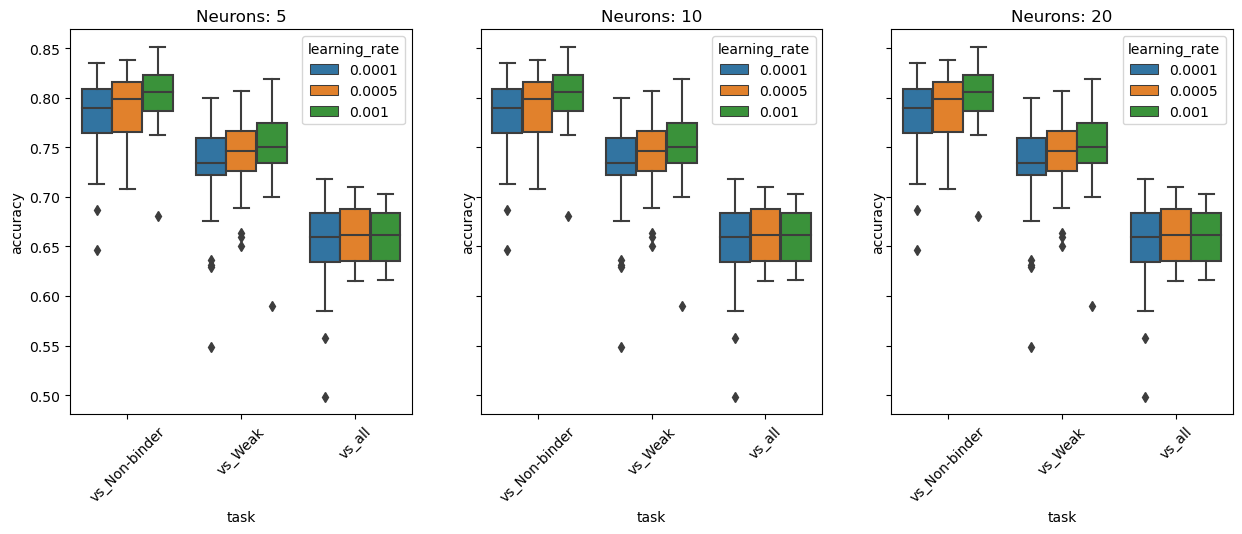

In [19]:
df_epochs_bsize_params = pd.read_csv("search_epochs_bsize_10neurons_lr0.001.csv")

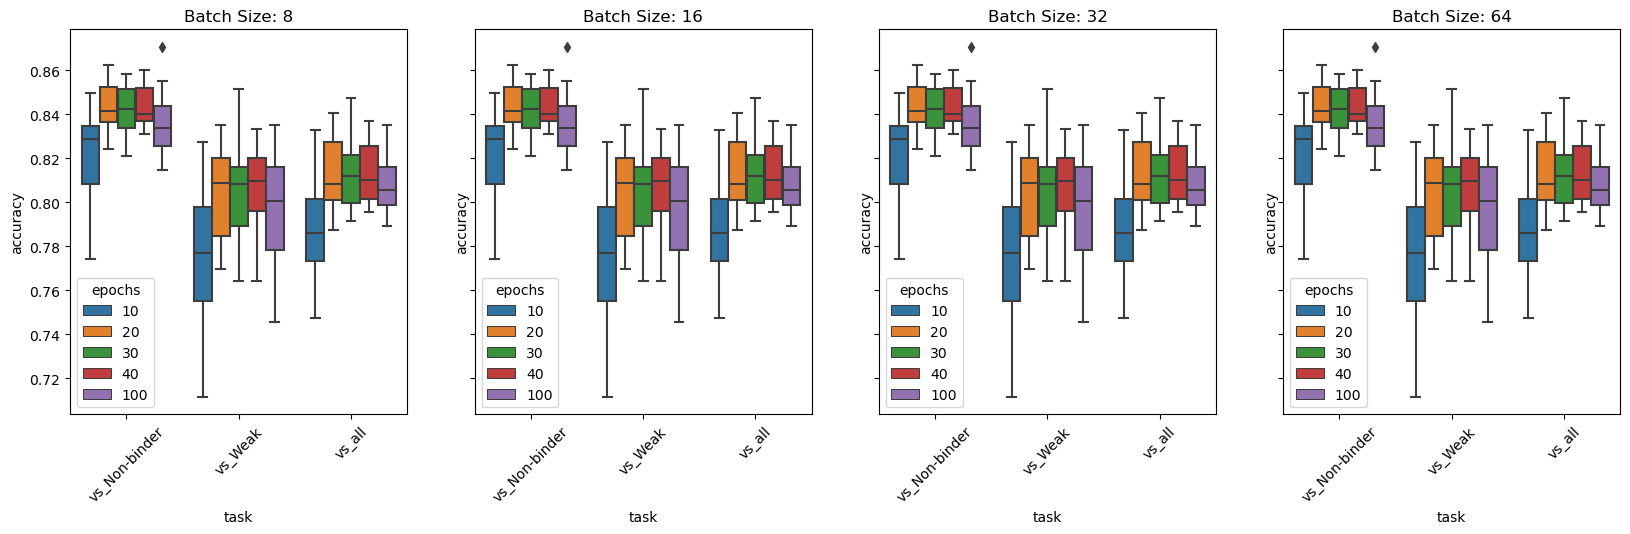

In [20]:
fig, ax = plt.subplots(1,4, sharey=True, figsize=(20,5))
for i, (batch_size, df) in enumerate(df_epochs_bsize_params.groupby('batch_size')):
    sns.boxplot(x='task', y='accuracy', hue='epochs', data=df_epochs_bsize_params, ax=ax[i], order=['vs_Non-binder', 'vs_Weak', 'vs_all'])
    ax[i].set_title(f'Batch Size: {batch_size}')
    ax[i].xaxis.set_tick_params(rotation=45)

In [24]:
df_epochs_bsize_params.task.unique()

array(['vs_Weak', 'vs_all', 'vs_Non-binder', 'shuffled_weak'],
      dtype=object)

In [27]:
df_epochs_bsize_params.groupby(["task", "epochs","batch_size"]).median().sort_values("accuracy", ascending=False)
#show max of median accuracy for each task
df_epochs_bsize_params.groupby(["task", "epochs","batch_size"]).median().sort_values("accuracy", ascending=False).groupby(["task","epochs","batch_size"]).max()

Unnamed: 0  neurons  learning_rate  accuracy
task          epochs batch_size                                              
shuffled_weak 10     8                  0.0     10.0          0.001  0.763287
                     16                 0.0     10.0          0.001  0.741867
                     32                 0.0     10.0          0.001  0.725568
                     64                 0.0     10.0          0.001  0.706079
              20     8                  0.0     10.0          0.001  0.768693
...                                     ...      ...            ...       ...
vs_all        40     64                 0.0     10.0          0.001  0.819441
              100    8                  0.0     10.0          0.001  0.805611
                     16                 0.0     10.0          0.001  0.801505
                     32                 0.0     10.0          0.001  0.809082
                     64                 0.0     10.0          0.001  0.809076

[80 rows x 4 columns]

In [28]:
grouping_df = df_epochs_bsize_params.groupby(["task", "epochs","batch_size"]).median().sort_values("accuracy", ascending=False).groupby(["task","epochs","batch_size"]).max()

In [30]:
#show for each task
grouping_df.loc['vs_Non-binder'].sort_values("accuracy", ascending=False)

Unnamed: 0  neurons  learning_rate  accuracy
epochs batch_size                                              
30     32                 0.0     10.0          0.001  0.848172
20     16                 0.0     10.0          0.001  0.847260
       8                  0.0     10.0          0.001  0.846753
40     64                 0.0     10.0          0.001  0.846028
       32                 0.0     10.0          0.001  0.845369
30     64                 0.0     10.0          0.001  0.844361
40     8                  0.0     10.0          0.001  0.842240
20     32                 0.0     10.0          0.001  0.841489
30     8                  0.0     10.0          0.001  0.840522
40     16                 0.0     10.0          0.001  0.838551
10     8                  0.0     10.0          0.001  0.837456
100    64                 0.0     10.0          0.001  0.835983
       32                 0.0     10.0          0.001  0.835571
20     64                 0.0     10.0          0.001  0.835384
30     16                 0.0     10.0          0.001  0.834902
10     16                 0.0     10.0          0.001  0.833180
100    8                  0.0     10.0          0.001  0.831494
10     32                 0.0     10.0          0.001  0.826301
100    16                 0.0     10.0          0.001  0.825674
10     64                 0.0     10.0          0.001  0.790043

In [31]:
grouping_df.loc['vs_Weak'].sort_values("accuracy", ascending=False)

Unnamed: 0  neurons  learning_rate  accuracy
epochs batch_size                                              
30     16                 0.0     10.0          0.001  0.815824
40     32                 0.0     10.0          0.001  0.813968
20     32                 0.0     10.0          0.001  0.811644
30     32                 0.0     10.0          0.001  0.811438
20     8                  0.0     10.0          0.001  0.809734
       16                 0.0     10.0          0.001  0.809320
40     64                 0.0     10.0          0.001  0.808922
       16                 0.0     10.0          0.001  0.806844
10     8                  0.0     10.0          0.001  0.806076
100    64                 0.0     10.0          0.001  0.805781
       32                 0.0     10.0          0.001  0.805587
40     8                  0.0     10.0          0.001  0.804527
20     64                 0.0     10.0          0.001  0.804402
30     8                  0.0     10.0          0.001  0.802633
       64                 0.0     10.0          0.001  0.801674
100    16                 0.0     10.0          0.001  0.799705
10     16                 0.0     10.0          0.001  0.787657
100    8                  0.0     10.0          0.001  0.787035
10     32                 0.0     10.0          0.001  0.770959
       64                 0.0     10.0          0.001  0.743199

In [32]:
grouping_df.loc['vs_all'].sort_values("accuracy", ascending=False)

Unnamed: 0  neurons  learning_rate  accuracy
epochs batch_size                                              
40     64                 0.0     10.0          0.001  0.819441
30     32                 0.0     10.0          0.001  0.816669
20     8                  0.0     10.0          0.001  0.816572
       16                 0.0     10.0          0.001  0.815631
40     8                  0.0     10.0          0.001  0.814720
30     8                  0.0     10.0          0.001  0.814181
40     16                 0.0     10.0          0.001  0.814025
30     16                 0.0     10.0          0.001  0.811030
20     32                 0.0     10.0          0.001  0.810925
100    32                 0.0     10.0          0.001  0.809082
       64                 0.0     10.0          0.001  0.809076
30     64                 0.0     10.0          0.001  0.808216
100    8                  0.0     10.0          0.001  0.805611
40     32                 0.0     10.0          0.001  0.805271
10     8                  0.0     10.0          0.001  0.804411
20     64                 0.0     10.0          0.001  0.801706
100    16                 0.0     10.0          0.001  0.801505
10     16                 0.0     10.0          0.001  0.797617
       32                 0.0     10.0          0.001  0.777801
       64                 0.0     10.0          0.001  0.761817